# 取り組み
+ Stx2大型欠失3アレルで**クラスタが3つに別れず、1つになっていた**


In [2]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if os.getcwd() != "/mnt/d/Research/DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)
print(os.getcwd())

/mnt/d/Research/DAJIN2


# 実験

### 準備

In [7]:
from src.DAJIN2.core import preprocess, classification, clustering, consensus, report
from collections import defaultdict
from collections import Counter

# # * 2-cut deletion
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    "tests/data/knockout/test_barcode25.fq.gz",
    "tests/data/knockout/test_barcode30.fq.gz",
    "tests/data/knockout/design_stx2.fa",
    "test-knockout",
    "mm10",
    True,
    14,
)

In [4]:
##########################################################
# Check inputs
##########################################################
preprocess.check_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.check_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.check_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.check_inputs.check_and_fetch_genome(GENOME)

##########################################################
# Format inputs
##########################################################
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)

preprocess.format_inputs.make_directories(TEMPDIR, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)


In [5]:
classif_sample = classification.classify_alleles(TEMPDIR, SAMPLE_NAME)
for classif in classif_sample:
    classif["SV"] = classification.detect_sv(classif["CSSPLIT"], threshold=50)

In [6]:
from src.DAJIN2.core.clustering import clustering
clust_sample = clustering.add_labels(classif_sample, TEMPDIR, CONTROL_NAME, FASTA_ALLELES, THREADS)

In [11]:
print(clust_sample[0].keys())
count = defaultdict(int)
for c in clust_sample:
    count[c["LABEL"]] += 1
print(count)

dict_keys(['QNAME', 'RNAME', 'CSSPLIT', 'ALLELE', 'PRESET', 'SV', 'LABEL'])
defaultdict(<class 'int'>, {1: 1, 2: 1448, 3: 2})


In [13]:
from __future__ import annotations
from itertools import groupby
from copy import deepcopy
from collections import defaultdict
from pathlib import Path
import midsv

from src.DAJIN2.core.preprocess.correct_knockin import extract_knockin_loci
from src.DAJIN2.core.clustering.preprocess import replace_both_ends_n
from src.DAJIN2.core.clustering.make_score import make_score
from src.DAJIN2.core.clustering.annotate_score import annotate_score
from src.DAJIN2.core.clustering.reorder_labels import reorder_labels
from src.DAJIN2.core.clustering.return_labels import return_labels

paths_midsv = list(Path(TEMPDIR, "midsv").glob(f"{CONTROL_NAME}_splice_*"))
cssplits_control_by_alleles = defaultdict(list)
for path_midsv in paths_midsv:
    midsv_control = midsv.read_jsonl(path_midsv)
    allele = path_midsv.stem.split("_")[-1]
    cssplits = [cs["CSSPLIT"].split(",") for cs in midsv_control]
    cssplits_control_by_alleles[allele] = cssplits
knockin_alleles = extract_knockin_loci(TEMPDIR)
labels_all = []
max_label = 0
classif_sample.sort(key=lambda x: (x["ALLELE"], x["SV"]))

In [14]:
allele = "deletion"
sv = True

In [15]:
cssplits_control = cssplits_control_by_alleles[allele]
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in classif_sample if cs["ALLELE"] == allele and cs["SV"] == sv]

In [16]:
cssplits_control = replace_both_ends_n(cssplits_control)
cssplits_sample = replace_both_ends_n(cssplits_sample)
mutation_score = make_score(cssplits_control, cssplits_sample, knockin_alleles[allele])
scores_control = annotate_score(cssplits_control, mutation_score)
scores_sample = annotate_score(cssplits_sample, mutation_score)
labels = return_labels(scores_sample, scores_control)
Counter(labels)

Counter({1: 1448})

In [17]:
small = "836991e0ff07"
medium = "d2a68de457cc"
large = "a0d18c462d05"

In [18]:
print(mutation_score[1500], "large")
print(mutation_score[2200], "all")
print(mutation_score[2500], "medium and large")
print(mutation_score[3000], "large")

{'N,N,N': 22.54987484961999} large
{} all
{'N,N,N': 49.822964952191974} medium and large
{'N,N,N': 17.196061326537006} large


In [19]:
midsv_sample = [cs for cs in classif_sample if cs["ALLELE"] == allele and cs["SV"] == sv]

In [24]:
for i, m in enumerate(midsv_sample):
    if small in m["QNAME"]:
        print(i, "small")
    if medium in m["QNAME"]:
        print(i, "medium")
    if large in m["QNAME"]:
        print(i, "large")


146 medium
1065 small
1254 large


In [28]:
scores_sample[146][2500:2510]

[49.822964952191974,
 49.822964952191974,
 49.822964952191974,
 49.822964952191974,
 49.822964952191974,
 49.822964952191974,
 49.822964952191974,
 49.822964952191974,
 49.822964952191974,
 49.822964952191974]

In [29]:
scores_sample[1065][2500:2510]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [30]:
scores_sample[1254][2500:2510]

[49.822964952191974,
 49.822964952191974,
 49.822964952191974,
 49.822964952191974,
 49.822964952191974,
 49.822964952191974,
 49.822964952191974,
 49.822964952191974,
 49.822964952191974,
 49.822964952191974]

In [35]:
from __future__ import annotations
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from collections import Counter

from src.DAJIN2.core.clustering.merge_clusters import merge_clusters
from src.DAJIN2.core.clustering.reorder_labels import reorder_labels

###############################################################################
# Dimension reduction
###############################################################################


def reduce_dimension(scores_sample: list[list], scores_control_subset: list[list]) -> np.array:
    scores = scores_sample + scores_control_subset
    n_components = min(20, len(scores[0]))
    pca = PCA(n_components=n_components).fit(scores)
    return pca.transform(scores)  # * variance


def optimize_labels(X: np.array, scores_sample: list[list], scores_control_subset: list[list]) -> list[int]:
    scores = scores_sample + scores_control_subset
    n_components = min(20, len(scores))
    for i in range(1, n_components):
        np.random.seed(seed=1)
        labels = GaussianMixture(n_components=i, random_state=1).fit_predict(X)
        labels = labels.tolist()
        labels_sample = labels[: len(scores_sample)]
        labels_control = labels[len(scores_sample) :]
        labels_merged = merge_clusters(labels_control, labels_sample)
        labels_reorder = reorder_labels(labels_merged)
        print(i, Counter(labels_reorder), Counter(labels_control)) # ! -----------------------------------------
        # if len(Counter(labels_control)) > 1:
        #     break
    return labels_reorder


###############################################################################
# main
###############################################################################


def return_labels(scores_sample: list[list], scores_control: list[list]) -> list[int]:
    np.random.seed(seed=1)
    X_control = reduce_dimension([], scores_control)
    labels = GaussianMixture(n_components=2, random_state=1).fit_predict(X_control)
    label_most = Counter(labels).most_common()[0][0]
    scores_control_subset = [s for l, s in zip(labels, scores_control) if l == label_most][:1000]
    X = reduce_dimension(scores_sample, scores_control_subset)
    labels = optimize_labels(X, scores_sample, scores_control_subset)
    return labels


In [38]:
_ = return_labels(scores_sample, scores_control)

1 Counter({1: 1448}) Counter({0: 812})
2 Counter({1: 1448}) Counter({1: 811, 0: 1})
3 Counter({2: 916, 1: 532}) Counter({1: 811, 2: 1})
4 Counter({2: 498, 1: 487, 3: 463}) Counter({1: 811, 2: 1})
5 Counter({2: 498, 1: 487, 3: 463}) Counter({1: 576, 4: 235, 2: 1})
6 Counter({2: 498, 1: 487, 3: 463}) Counter({4: 317, 1: 259, 5: 235, 2: 1})
7 Counter({2: 495, 1: 482, 3: 463, 4: 8}) Counter({4: 311, 1: 257, 5: 229, 6: 14, 2: 1})
8 Counter({2: 495, 3: 463, 1: 401, 4: 81, 5: 8}) Counter({1: 312, 6: 256, 4: 229, 5: 14, 7: 1})
9 Counter({2: 495, 3: 463, 1: 401, 4: 81, 5: 8}) Counter({1: 271, 4: 229, 6: 201, 8: 96, 5: 14, 7: 1})
10 Counter({2: 490, 4: 463, 1: 389, 5: 79, 3: 19, 6: 8}) Counter({1: 271, 4: 229, 6: 201, 8: 96, 5: 14, 7: 1})
11 Counter({2: 497, 4: 463, 1: 392, 5: 70, 3: 18, 6: 8}) Counter({1: 271, 4: 229, 6: 201, 8: 96, 5: 14, 10: 1})
12 Counter({2: 493, 4: 463, 1: 400, 6: 43, 5: 22, 3: 19, 7: 8}) Counter({1: 271, 4: 229, 6: 201, 8: 96, 5: 14, 7: 1})
13 Counter({3: 493, 5: 463, 1: 

### Controlが2つに分かれている！

```
2 Counter({1: 1448}) Counter({1: 811, 0: 1})
````

In [41]:
np.random.seed(seed=1)
X_control = reduce_dimension([], scores_control)
labels = GaussianMixture(n_components=2, random_state=1).fit_predict(X_control)
print(Counter(labels))
label_most = Counter(labels).most_common()[0][0]
scores_control_subset = [s for l, s in zip(labels, scores_control) if l == label_most][:1000]
X = reduce_dimension(scores_sample, scores_control_subset)
# labels = optimize_labels(X, scores_sample, scores_control_subset)


Counter({1: 812, 0: 157})


In [70]:
i = 2
np.random.seed(seed=1)
labels = GaussianMixture(n_components=i, random_state=1).fit_predict(X)
labels = labels.tolist()
labels_sample = labels[: len(scores_sample)]
labels_control = labels[len(scores_sample) :]
labels_merged = merge_clusters(labels_control, labels_sample)
labels_reorder = reorder_labels(labels_merged)
print(i, Counter(labels_reorder), Counter(labels_control)) # ! -----------------------------------------

2 Counter({1: 1448}) Counter({1: 811, 0: 1})


In [71]:
[i for i, c in enumerate(labels_control) if c == 0]

[502]

In [74]:
scores_control_subset[502]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


(0.0, 100.0)

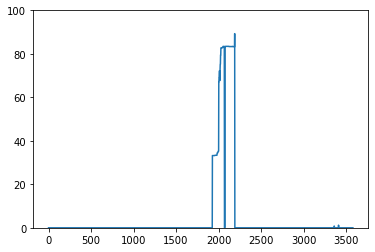

In [75]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(scores_control_subset[502])
plt.ylim(0, 100)

(0.0, 100.0)

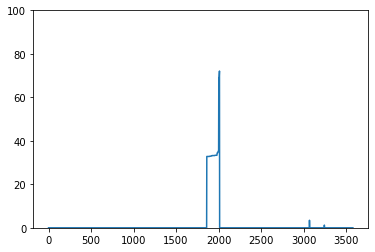

In [77]:
plt.plot(scores_control_subset[100])
plt.ylim(0, 100)

In [85]:
count = Counter({1: 811, 0: 1})
[label for label, number in count.items() if number/sum(count.values()) > 0.05]

[1]

In [107]:
def optimize_labels(X: np.array, scores_sample: list[list], scores_control_subset: list[list]) -> list[int]:
    scores = scores_sample + scores_control_subset
    n_components = min(20, len(scores))
    labels_results = [1] * len(scores_sample)
    print(labels_results[:10])
    for i in range(1, n_components):
        np.random.seed(seed=1)
        labels = GaussianMixture(n_components=i, random_state=1).fit_predict(X)
        labels = labels.tolist()
        labels_sample = labels[: len(scores_sample)]
        labels_control = labels[len(scores_sample) :]
        labels_merged = merge_clusters(labels_control, labels_sample)
        labels_reorder = reorder_labels(labels_merged)
        count_control = Counter(labels_control)
        # Reads < 1% in the control are considered clustering errors and are not counted
        num_labels_control = sum(1 for reads in count_control.values() if reads/sum(count_control.values())*100 > 1)
        print(i, Counter(labels_reorder), Counter(labels_control), num_labels_control) # ! -----------------------------------------
        if num_labels_control > 1:
            return labels_results
        labels_results = labels_reorder
    return labels_results


In [108]:
labels_reorder = optimize_labels(X, scores_sample, scores_control_subset)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
1 Counter({1: 1448}) Counter({0: 812}) 1
2 Counter({1: 1448}) Counter({1: 811, 0: 1}) 1
3 Counter({2: 916, 1: 532}) Counter({1: 811, 2: 1}) 1
4 Counter({2: 498, 1: 487, 3: 463}) Counter({1: 811, 2: 1}) 1
5 Counter({2: 498, 1: 487, 3: 463}) Counter({1: 576, 4: 235, 2: 1}) 2


In [106]:
Counter(cont)

Counter({1: 576, 4: 235, 2: 1})

## Retry

In [111]:
%%bash
# Stx2 deletion knockout
rm -rf DAJINResults/.tempdir/test-knockout/
time python misc/quickstart.py
ls -lh DAJINResults/.tempdir/test-knockout/report/BAM/test_barcode25/

Traceback (most recent call last):
  File "/mnt/d/Research/DAJIN2/misc/quickstart.py", line 125, in <module>
    preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, threads=THREADS)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/preprocess/mappy_align.py", line 100, in output_sam
    output_sam.write_text("\n".join(sam))
  File "/home/kuno/miniconda/lib/python3.10/pathlib.py", line 1154, in write_text
    with self.open(mode='w', encoding=encoding, errors=errors, newline=newline) as f:
  File "/home/kuno/miniconda/lib/python3.10/pathlib.py", line 1119, in open
    return self._accessor.open(self, mode, buffering, encoding, errors,
FileNotFoundError: [Errno 2] No such file or directory: 'DAJINResults/.tempdir/test-knockout/sam/test_barcode30_map-ont_control.sam'

real	0m12.273s
user	0m7.354s
sys	0m1.977s
ls: cannot access 'DAJINResults/.tempdir/test-knockout/report/BAM/test_barcode25/': No such file or directory


processing test-knockout...



real	5m19.330s
user	5m37.491s
sys	0m54.137s


total 30M
-rwxrwxrwx 1 kuno kuno 6.3M Feb  8 14:07 test_barcode25.bam
-rwxrwxrwx 1 kuno kuno  62K Feb  8 14:07 test_barcode25.bam.bai
-rwxrwxrwx 1 kuno kuno 1.5M Feb  8 14:07 test_barcode25_allele1_deletion_sv_34.321%.bam
-rwxrwxrwx 1 kuno kuno  62K Feb  8  2023 test_barcode25_allele1_deletion_sv_34.321%.bam.bai
-rwxrwxrwx 1 kuno kuno 1.6M Feb  8 14:07 test_barcode25_allele2_deletion_sv_33.563%.bam
-rwxrwxrwx 1 kuno kuno  62K Feb  8 14:07 test_barcode25_allele2_deletion_sv_33.563%.bam.bai
-rwxrwxrwx 1 kuno kuno 1.7M Feb  8  2023 test_barcode25_allele3_deletion_sv_31.909%.bam
-rwxrwxrwx 1 kuno kuno  62K Feb  8  2023 test_barcode25_allele3_deletion_sv_31.909%.bam.bai
-rwxrwxrwx 1 kuno kuno 2.8K Feb  8  2023 test_barcode25_allele4_inversion_sv_0.138%.bam
-rwxrwxrwx 1 kuno kuno  62K Feb  8  2023 test_barcode25_allele4_inversion_sv_0.138%.bam.bai
-rwxrwxrwx 1 kuno kuno 4.7K Feb  8  2023 test_barcode25_allele5_deletion_mutated_0.069%.bam
-rwxrwxrwx 1 kuno kuno  62K Feb  8  2023 test_barcode2

# 結果

- Stx2 knockoutは3アレルに分かれるようになった
    - `optimize_labels`にて、極小数のリードが原因でコントロール内で分かれてしまっていた
      - `Counter({1: 811, 0: 1})`といった感じ
    - なので1%未満のクラスタは無視することにした

# 次回の課題

+ [x] ~~Stx2のクラスタリングがうまく行っていないので原因を探索する~~
+ [ ] 点変異、欠失、ノックインのデザインで動くかを確認する
+ [ ] `preprocess.correct_sequence_error.replace_atmark`のコードがわかりにくい
    + テストを用意してリファクタリングする
+ [ ] right_loxpがいまいちな理由を考察する
+ [ ] Insertionのなかにある変異を同定する手法を考案する
+ [ ] cis変異の両端が欠失している場合に、Nで置き換えるとtransとなってしまうのをどうするか（`replace_n`）
+ [ ] 短いリードの扱いをどうするべきか